In [ ]:
# @title Instalação do deap
! pip install deap

In [ ]:
# @title Download dos dados de entrada (Asimétricos)

!wget http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/atsp/ft53.atsp.gz
!gunzip ft53.atsp.gz

!wget http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/atsp/rbg443.atsp.gz
!gunzip rbg443.atsp.gz

--2025-03-06 22:25:05--  http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/atsp/ft53.atsp.gz
Resolving comopt.ifi.uni-heidelberg.de (comopt.ifi.uni-heidelberg.de)... 129.206.106.221
Connecting to comopt.ifi.uni-heidelberg.de (comopt.ifi.uni-heidelberg.de)|129.206.106.221|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6031 (5.9K) [application/octet-stream]
Saving to: ‘ft53.atsp.gz’

ft53.atsp.gz        100%[===================>]   5.89K  --.-KB/s    in 0s      

2025-03-06 22:25:09 (40.4 MB/s) - ‘ft53.atsp.gz’ saved [6031/6031]

gzip: ft53.atsp already exists; do you wish to overwrite (y or n)? ^C
--2025-03-06 22:25:59--  http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/atsp/rbg443.atsp.gz
Resolving comopt.ifi.uni-heidelberg.de (comopt.ifi.uni-heidelberg.de)... ^C
gzip: rbg443.atsp.gz: No such file or directory


In [ ]:
# @title Download dos dados de entrada (Simétricos)

!wget http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/brazil58.tsp.gz
!gunzip brazil58.tsp.gz

!wget http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/brg180.tsp.gz
!gunzip brg180.tsp.gz

--2025-03-11 15:23:03--  http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/brazil58.tsp.gz
Resolving comopt.ifi.uni-heidelberg.de (comopt.ifi.uni-heidelberg.de)... 129.206.106.221
Connecting to comopt.ifi.uni-heidelberg.de (comopt.ifi.uni-heidelberg.de)|129.206.106.221|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3947 (3.9K) [application/octet-stream]
Saving to: ‘brazil58.tsp.gz’

brazil58.tsp.gz     100%[===================>]   3.85K  --.-KB/s    in 0s      

2025-03-11 15:23:07 (326 MB/s) - ‘brazil58.tsp.gz’ saved [3947/3947]

gzip: brazil58.tsp already exists; do you wish to overwrite (y or n)? ^C
--2025-03-11 15:47:14--  http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/brg180.tsp.gz
Resolving comopt.ifi.uni-heidelberg.de (comopt.ifi.uni-heidelberg.de)... ^C
gzip: brg180.tsp.gz: No such file or directory


In [139]:
# @title Import de Bibliotecas

import numpy as np
import matplotlib.pyplot as plt
import random
import os
import time
import pytz
from datetime import datetime
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

In [ ]:
# @title Função p/ leitura dos dados de entrada (Asimétricos)

# Retorna uma tupla (distancias, ncidades)
def read_data(fpath):
  distances, n_cities = None, None

  with open(fpath, "r") as f:
      lines = f.readlines()
      starting_i = 0
      for line in lines:
        starting_i +=1
        if 'EDGE_WEIGHT_SECTION' in line:
          break

        if 'DIMENSION' in line:
          n_cities = int(line.split()[-1])

      distances = np.zeros((n_cities,n_cities), dtype=np.int64)
      i, j = 0, 0
      for line in lines[starting_i:]:
        if 'EOF' in line or i >= n_cities:
          break

        for distance in line.split():
          if i==j: # Tratando os dados para facilitar a implementação
            distances[i][j] = 9999999 # Sair de i e ir para i é indesejável
          else:
            distances[i][j] = int(distance)
          j += 1
          if j >= n_cities:
            j = 0
            i += 1
  return distances, n_cities

In [140]:
# @title Função p/ leitura dos dados de entrada (Simétricos)

# Retorna uma tupla (distancias, ncidades)
def read_data(fpath):
  distances, n_cities = None, None

  with open(fpath, "r") as f:
      lines = f.readlines()
      starting_i = 0
      for line in lines:
        starting_i +=1
        if 'EDGE_WEIGHT_SECTION' in line:
          break

        if 'DIMENSION' in line:
          n_cities = int(line.split()[-1])

      distances = np.zeros((n_cities,n_cities), dtype=np.int64)
      i, j = 0, 1 # Os valores na diagonal não são apresentados
      for line in lines[starting_i:]:
        if 'EOF' in line or i >= n_cities:
          break

        for distance in line.split():
          distances[i][j] = int(distance)
          j += 1
          if j >= n_cities:
            i += 1
            j = i+1

  distances = distances + distances.T # Refletir a matriz

  for i in range(n_cities):
    distances[i][i] = 9999999 # Indesejável sair de i para i

  return distances, n_cities

In [141]:
filepath = 'brazil58.tsp' # @param {'type':'string'}
distances, n_cities = read_data(filepath)

print(f"Arquivo {filepath} lido com sucesso!")
print(f"Número de cidades: {n_cities}")
print("Matriz de distâncias:")
print(distances)


Arquivo brazil58.tsp lido com sucesso!
Número de cidades: 58
Matriz de distâncias:
[[9999999    2635    2713 ...    3870    1417     739]
 [   2635 9999999     314 ...    2072    1196    1517]
 [   2713     314 9999999 ...    1882    2699    1557]
 ...
 [   3870    2072    1882 ... 9999999    2328    2986]
 [   1417    1196    2699 ...    2328 9999999     962]
 [    739    1517    1557 ...    2986     962 9999999]]


In [142]:
# @title Minimização da FO

# Problema de minimização
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# Indivíduo derivado de uma permutação
creator.create("Individual", list, fitness=creator.FitnessMin)

/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [143]:
# @title Criação da Toolbox + registros do indivíduo e população
toolbox = base.Toolbox()
toolbox.register("indices", random.sample, range(n_cities), n_cities) # A solução é representada como um permutação
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual) # População é uma lista de indivíduos

In [144]:
# @title Função Objetivo

def fitness(individual):
  distance = 0 # Distância total viajada
  for i in range(n_cities-1):
    distance += distances[individual[i]][individual[i+1]]
  distance += distances[individual[n_cities-1]][individual[0]] # Volta para a cidade original

  return distance, # Como a solução é uma permutação, não há necessidade de preocupar-se com infrações das restrições

In [145]:
# @title Registro da FO + operadores (cruzamento, mutação e seleção)

toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxOrdered)  # Crossover ordenado
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.2)  # Mutação por troca de cidades
toolbox.register("select", tools.selTournament, tournsize=3)

In [146]:
# @title Pipeline experimental

# Retorna (melhor rota, distância total percorrida na melhor rota, objeto de estatísticas, logbook)
def main(MU=300, LAMBDA_=300, CXPB=0.6, MUTPB=0.4, NGEN=500, SEED=None, verbose=True):
  if SEED is not None:
    random.seed(SEED)
  pop = toolbox.population(n=MU)  # População inicial
  hof = tools.HallOfFame(1)  # Melhor solução encontrada
  stats = tools.Statistics(lambda ind: ind.fitness.values)
  stats.register("min", np.min)
  stats.register("avg", np.mean)

  # Evolução com algoritmo genético
  #algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.2, ngen=200, stats=stats, halloffame=hof, verbose=verbose)
  pop, log = algorithms.eaMuPlusLambda(pop, toolbox, mu=MU, lambda_=LAMBDA_, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN, stats=stats, halloffame=hof, verbose=verbose)
  #algorithms.eaMuCommaLambda(pop, toolbox, mu=100, lambda_=400, cxpb=0.7, mutpb=0.2, ngen=200, stats=stats, halloffame=hof, verbose=verbose)

  if verbose:
    print("\nMelhor rota encontrada:", hof[0])
    print("Distância total:", fitness(hof[0])[0])

  return hof[0], fitness(hof[0])[0], stats, log

# Tunando Hiperparâmetros

Nesta seção abaixo iremos fazer uma tunagem de hiperparâmetros em pares. Isto é, dado um par de hiperparâmetros, iremos testar algumas de suas combinações e selecionar a melhor.

Cada teste consistirá em 3 execuções. A configuração que vencer em mais testes será escolhida. Em caso de empate, o desempate será feito de maneira aleatória.

Vencer = ter a melhor FO condicionada a uma curva de convergência suave. Uma descida abrupta para o melhor valor será desconsiderada.

Os testes serão feitos com a brazil58.tsp

Pares definidos:
- μ e λ ⇒ (300, 200), (300, 300), (300, 500)
- Prob. Crossover e Prob. Mutação ⇒ (0.7, 0.3), (0.6, 0.4), (0.5, 0.5), (0.4, 0.6), (0.3, 0.7)


# μ e λ

gen	nevals	min  	avg   
0  	300   	95220	123206
1  	200   	95220	117102
2  	200   	95220	113062
3  	200   	95220	109283
4  	200   	93837	106694
5  	200   	90668	102977
6  	200   	90668	99756.1
7  	200   	87502	96803.4
8  	200   	86516	94114.2
9  	200   	83564	92274.3
10 	200   	83564	90496.1
11 	200   	78159	88817.8
12 	200   	77790	87392.3
13 	200   	77790	85879.8
14 	200   	77748	84364.8
15 	200   	77748	83081.3
16 	200   	77748	81906.4
17 	200   	75463	79741.8
18 	200   	69770	78536.8
19 	200   	69770	77762  
20 	200   	69770	77204.5
21 	200   	69770	75592.4
22 	200   	68364	74204.3
23 	200   	68249	72552.8
24 	200   	67747	70937  
25 	200   	67747	69968  
26 	200   	67290	69702  
27 	200   	66962	69138.4
28 	200   	66084	68720.5
29 	200   	64987	68290  
30 	200   	64597	67557.2
31 	200   	63659	66974.9
32 	200   	62646	66525.8
33 	200   	62644	66098.8
34 	200   	62644	65650.9
35 	200   	61539	64867.2
36 	200   	60780	64651.1
37 	200   	60619	63725.3
38 	200   	60619	62905.1
39 	200

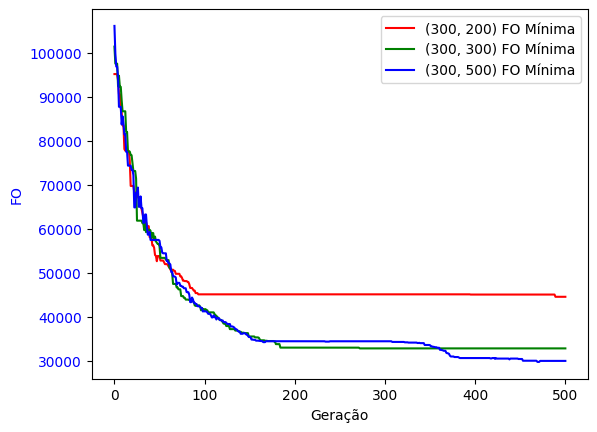

In [ ]:
# @title μ e λ (Gráfico de convergência)

PAIRS = [(300, 200), (300, 300), (300, 500)]
COLORS = ['r', 'g', 'b']
BEST_FITS = []
LOGS = []

# Realização dos testes
for MU, LAMBDA_ in PAIRS:
  NGEN = 500
  _, f, _, log = main(NGEN=NGEN, MU=MU, LAMBDA_=LAMBDA_)
  BEST_FITS.append(f)
  LOGS.append(log)

# Plot gráfico
fig, ax1 = plt.subplots()
ax1.set_xlabel("Geração")
ax1.set_ylabel("FO", color="b")
for tl in ax1.get_yticklabels():
    tl.set_color("b")

lns = []
for i, (MU, LAMBDA_) in enumerate(PAIRS):
  gen = list(range(NGEN+1))
  fit_mins = LOGS[i].select('min')
  line = ax1.plot(gen, fit_mins, f"{COLORS[i]}-", label=f"({MU}, {LAMBDA_}) FO Mínima")
  lns = lns + line

labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="upper right")

plt.show()

In [ ]:
# @title μ e λ (Melhores fitnesses)

print("Melhores fitness para cada par:")
for MU, LAMBDA_ in PAIRS:
  print(f"({MU}, {LAMBDA_}) -> {BEST_FITS[PAIRS.index((MU, LAMBDA_))]}")

print("\nMelhor par:")
print(PAIRS[BEST_FITS.index(min(BEST_FITS))])

Melhores fitness para cada par:
(300, 200) -> 44553
(300, 300) -> 32814
(300, 500) -> 29736

Melhor par:
(300, 500)


# Resultados μ e λ

O melhor par é (300, 500) já que venceu em dois de três testes!

# Prob. Crossover e Prob. Mutação

gen	nevals	min   	avg   
0  	300   	100475	124019
1  	500   	100475	118266
2  	500   	93280 	113953
3  	500   	98199 	110528
4  	500   	93604 	108004
5  	500   	86544 	104667
6  	500   	86544 	102031
7  	500   	85872 	99247.7
8  	500   	85793 	96544.7
9  	500   	82131 	94990.1
10 	500   	82131 	93246.4
11 	500   	81641 	91110.3
12 	500   	80276 	88977.9
13 	500   	75192 	87193.5
14 	500   	75192 	85802.2
15 	500   	71267 	84860.7
16 	500   	73415 	83556.1
17 	500   	71570 	82037.7
18 	500   	71570 	80885.4
19 	500   	69446 	79353.2
20 	500   	69446 	78515.1
21 	500   	68520 	77166.3
22 	500   	69200 	75929.3
23 	500   	67574 	74767.7
24 	500   	66112 	73376.5
25 	500   	66112 	72650.7
26 	500   	61159 	71882.8
27 	500   	63511 	71463.5
28 	500   	63325 	70215.5
29 	500   	60437 	69144.3
30 	500   	60437 	68268.1
31 	500   	60437 	67442.5
32 	500   	59336 	66094.8
33 	500   	58047 	64858.7
34 	500   	55863 	64171.9
35 	500   	55863 	63413  
36 	500   	56446 	63088.3
37 	500   	54900 	62

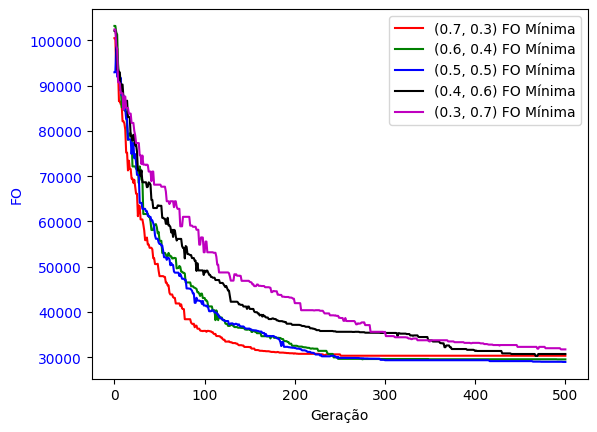

In [ ]:
# @title Prob. Crossover e Prob. Mutação (gráfico de convergência)

PAIRS = [(0.7, 0.3), (0.6, 0.4), (0.5, 0.5), (0.4, 0.6), (0.3, 0.7)]
COLORS = ['r', 'g', 'b', 'k', 'm']
BEST_FITS = []
LOGS = []

# Realização dos testes
for CXPB, MUTPB in PAIRS:
  NGEN = 500
  _, f, _, log = main(MU=300, LAMBDA_=500, NGEN=NGEN, CXPB=CXPB, MUTPB=MUTPB)
  BEST_FITS.append(f)
  LOGS.append(log)

# Plot gráfico
fig, ax1 = plt.subplots()
ax1.set_xlabel("Geração")
ax1.set_ylabel("FO", color="b")
for tl in ax1.get_yticklabels():
    tl.set_color("b")

lns = []
for i, (CXPB, MUTPB) in enumerate(PAIRS):
  gen = list(range(NGEN+1))
  fit_mins = LOGS[i].select('min')
  line = ax1.plot(gen, fit_mins, f"{COLORS[i]}-", label=f"({CXPB}, {MUTPB}) FO Mínima")
  lns = lns + line

labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="upper right")

plt.show()

In [ ]:
# @title Prob. Crossover e Prob. Mutação (Melhores fitnesses)

print("Melhores fitness para cada par:")
for CXPB, MUTPB in PAIRS:
  print(f"({CXPB}, {MUTPB}) -> {BEST_FITS[PAIRS.index((CXPB, MUTPB))]}")

print("\nMelhor par:")
print(PAIRS[BEST_FITS.index(min(BEST_FITS))])

Melhores fitness para cada par:
(0.7, 0.3) -> 30006
(0.6, 0.4) -> 29384
(0.5, 0.5) -> 28971
(0.4, 0.6) -> 30308
(0.3, 0.7) -> 31741

Melhor par:
(0.5, 0.5)


# Resultados Prob. Crossover e Prob. Mutação

O melhor par é (0.5, 0.5) já que venceu em dois de três testes!

# Execução experimental

In [ ]:
# @title Execução e registro dos logs

LOG_BASE_DIR = "/content/drive/MyDrive/ResultadosCompEvolutiva"
EXPERIMENT_NAME = "Brazil58_MuPlusLambda" # @param {type:"string"}
OPTIMAL_VALUE = 25395 # @param {type:"number"}
N = 33
NOTES = "mu=300, lambda_=500, cxpb=0.5, mutpb=0.5, ngen=500, OPTIMAL_VALUE=25395" # @param {type:"string"}

# Criando o diretório de log
LOG_DIR = os.path.join(LOG_BASE_DIR, EXPERIMENT_NAME)
os.makedirs(LOG_DIR)

# Metadados
timezone_sao_paulo = pytz.timezone("America/Sao_Paulo")
date_time_now = datetime.now(timezone_sao_paulo)
with open(os.path.join(LOG_DIR, 'notes.txt'), "w+") as f:
  f.write(f"Experimento começando em: {date_time_now.strftime('%Y-%m-%d %H:%M:%S')}")
  f.write("\nNotas sobre o experimento estão registradas abaixo\n")
  f.write(NOTES)

# Resultados: desempenho
with open(os.path.join(LOG_DIR, 'results.csv'), "w+") as f:
  f.write("index,best_fitness,time_in_seconds\n")

# Resultados: caminhos encontrados
with open(os.path.join(LOG_DIR, 'paths.csv'), "w+") as f:
  f.write("index,path\n")

# Resultados: seeds para reproducibilidade
with open(os.path.join(LOG_DIR, 'seeds.csv'), "w+") as f:
  f.write("index,seed\n")

# Resultados: melhor fitness obtido em cada geração de uma execução
with open(os.path.join(LOG_DIR, 'logs.csv'), "w+") as f:
  f.write("index,min_fit_through_gens\n")

# Experimentação de fato
NGEN = 500
FITNESSES = []
TIMES = []
for i in range(N):
  SEED = np.random.randint(1000000) # de zero a um milhao
  print(f"Execução {i+1} iniciando em: {datetime.now(timezone_sao_paulo).strftime('%Y-%m-%d %H:%M:%S')}.")
  start = time.time()
  h, f, _, logs = main(NGEN=NGEN, MU=300, LAMBDA_=500, CXPB=0.5, MUTPB=0.5, verbose=False)
  end = time.time()
  print(f"Execução {i+1} finalizada. Tempo gasto (s): {end-start}. Registrando os logs...")

  FITNESSES.append(f)
  TIMES.append(end-start)

  # Logs
  with open(os.path.join(LOG_DIR, 'results.csv'), "a") as file_:
    file_.write(f"{i},{f},{end-start}\n")

  with open(os.path.join(LOG_DIR, 'paths.csv'), "a") as f:
    f.write(f"{i},{h}\n")

  with open(os.path.join(LOG_DIR, 'seeds.csv'), "a") as f:
    f.write(f"{i},{SEED}\n")

  with open(os.path.join(LOG_DIR, 'logs.csv'), "a") as f:
    f.write(f"{i},{logs.select('min')}\n")

def gap(melhor_solucao_encontrada, solucao_otima):
  return 100*((melhor_solucao_encontrada - solucao_otima)/solucao_otima)

# Resultados: agregados
with open(os.path.join(LOG_DIR, 'results_aggregated.csv'), "w+") as f:
  f.write(f"type,worst,best,mean,std,gap\n")
  f.write(f"fitness,{max(FITNESSES)},{min(FITNESSES)},{np.mean(FITNESSES)},{np.std(FITNESSES)},{gap(min(FITNESSES), OPTIMAL_VALUE)}\n")
  f.write(f"time,{max(TIMES)},{min(TIMES)},{np.mean(TIMES)},{np.std(TIMES)},-\n")

# Resultados: Boxplot
plt.boxplot(FITNESSES, labels=[""])
plt.title(EXPERIMENT_NAME)
plt.ylabel("FO")


plt.savefig(os.path.join(LOG_DIR, 'boxplot.png'), dpi=300, bbox_inches="tight")
plt.show()


Execução 1 iniciando em: 2025-03-11 13:43:30.
Execução 1 finalizada. Tempo gasto (s): 32.34149646759033. Registrando os logs...
Execução 2 iniciando em: 2025-03-11 13:44:02.
Execução 2 finalizada. Tempo gasto (s): 30.533966779708862. Registrando os logs...
Execução 3 iniciando em: 2025-03-11 13:44:33.
Execução 3 finalizada. Tempo gasto (s): 30.454373598098755. Registrando os logs...
Execução 4 iniciando em: 2025-03-11 13:45:03.
Execução 4 finalizada. Tempo gasto (s): 30.232885360717773. Registrando os logs...
Execução 5 iniciando em: 2025-03-11 13:45:33.
Execução 5 finalizada. Tempo gasto (s): 31.799070835113525. Registrando os logs...
Execução 6 iniciando em: 2025-03-11 13:46:05.
Execução 6 finalizada. Tempo gasto (s): 30.455589056015015. Registrando os logs...
Execução 7 iniciando em: 2025-03-11 13:46:36.
Execução 7 finalizada. Tempo gasto (s): 30.22394633293152. Registrando os logs...
Execução 8 iniciando em: 2025-03-11 13:47:06.
Execução 8 finalizada. Tempo gasto (s): 29.9377722740